- Click and drag to draw
- Press ENTER when finished
- Press SPACE to clear


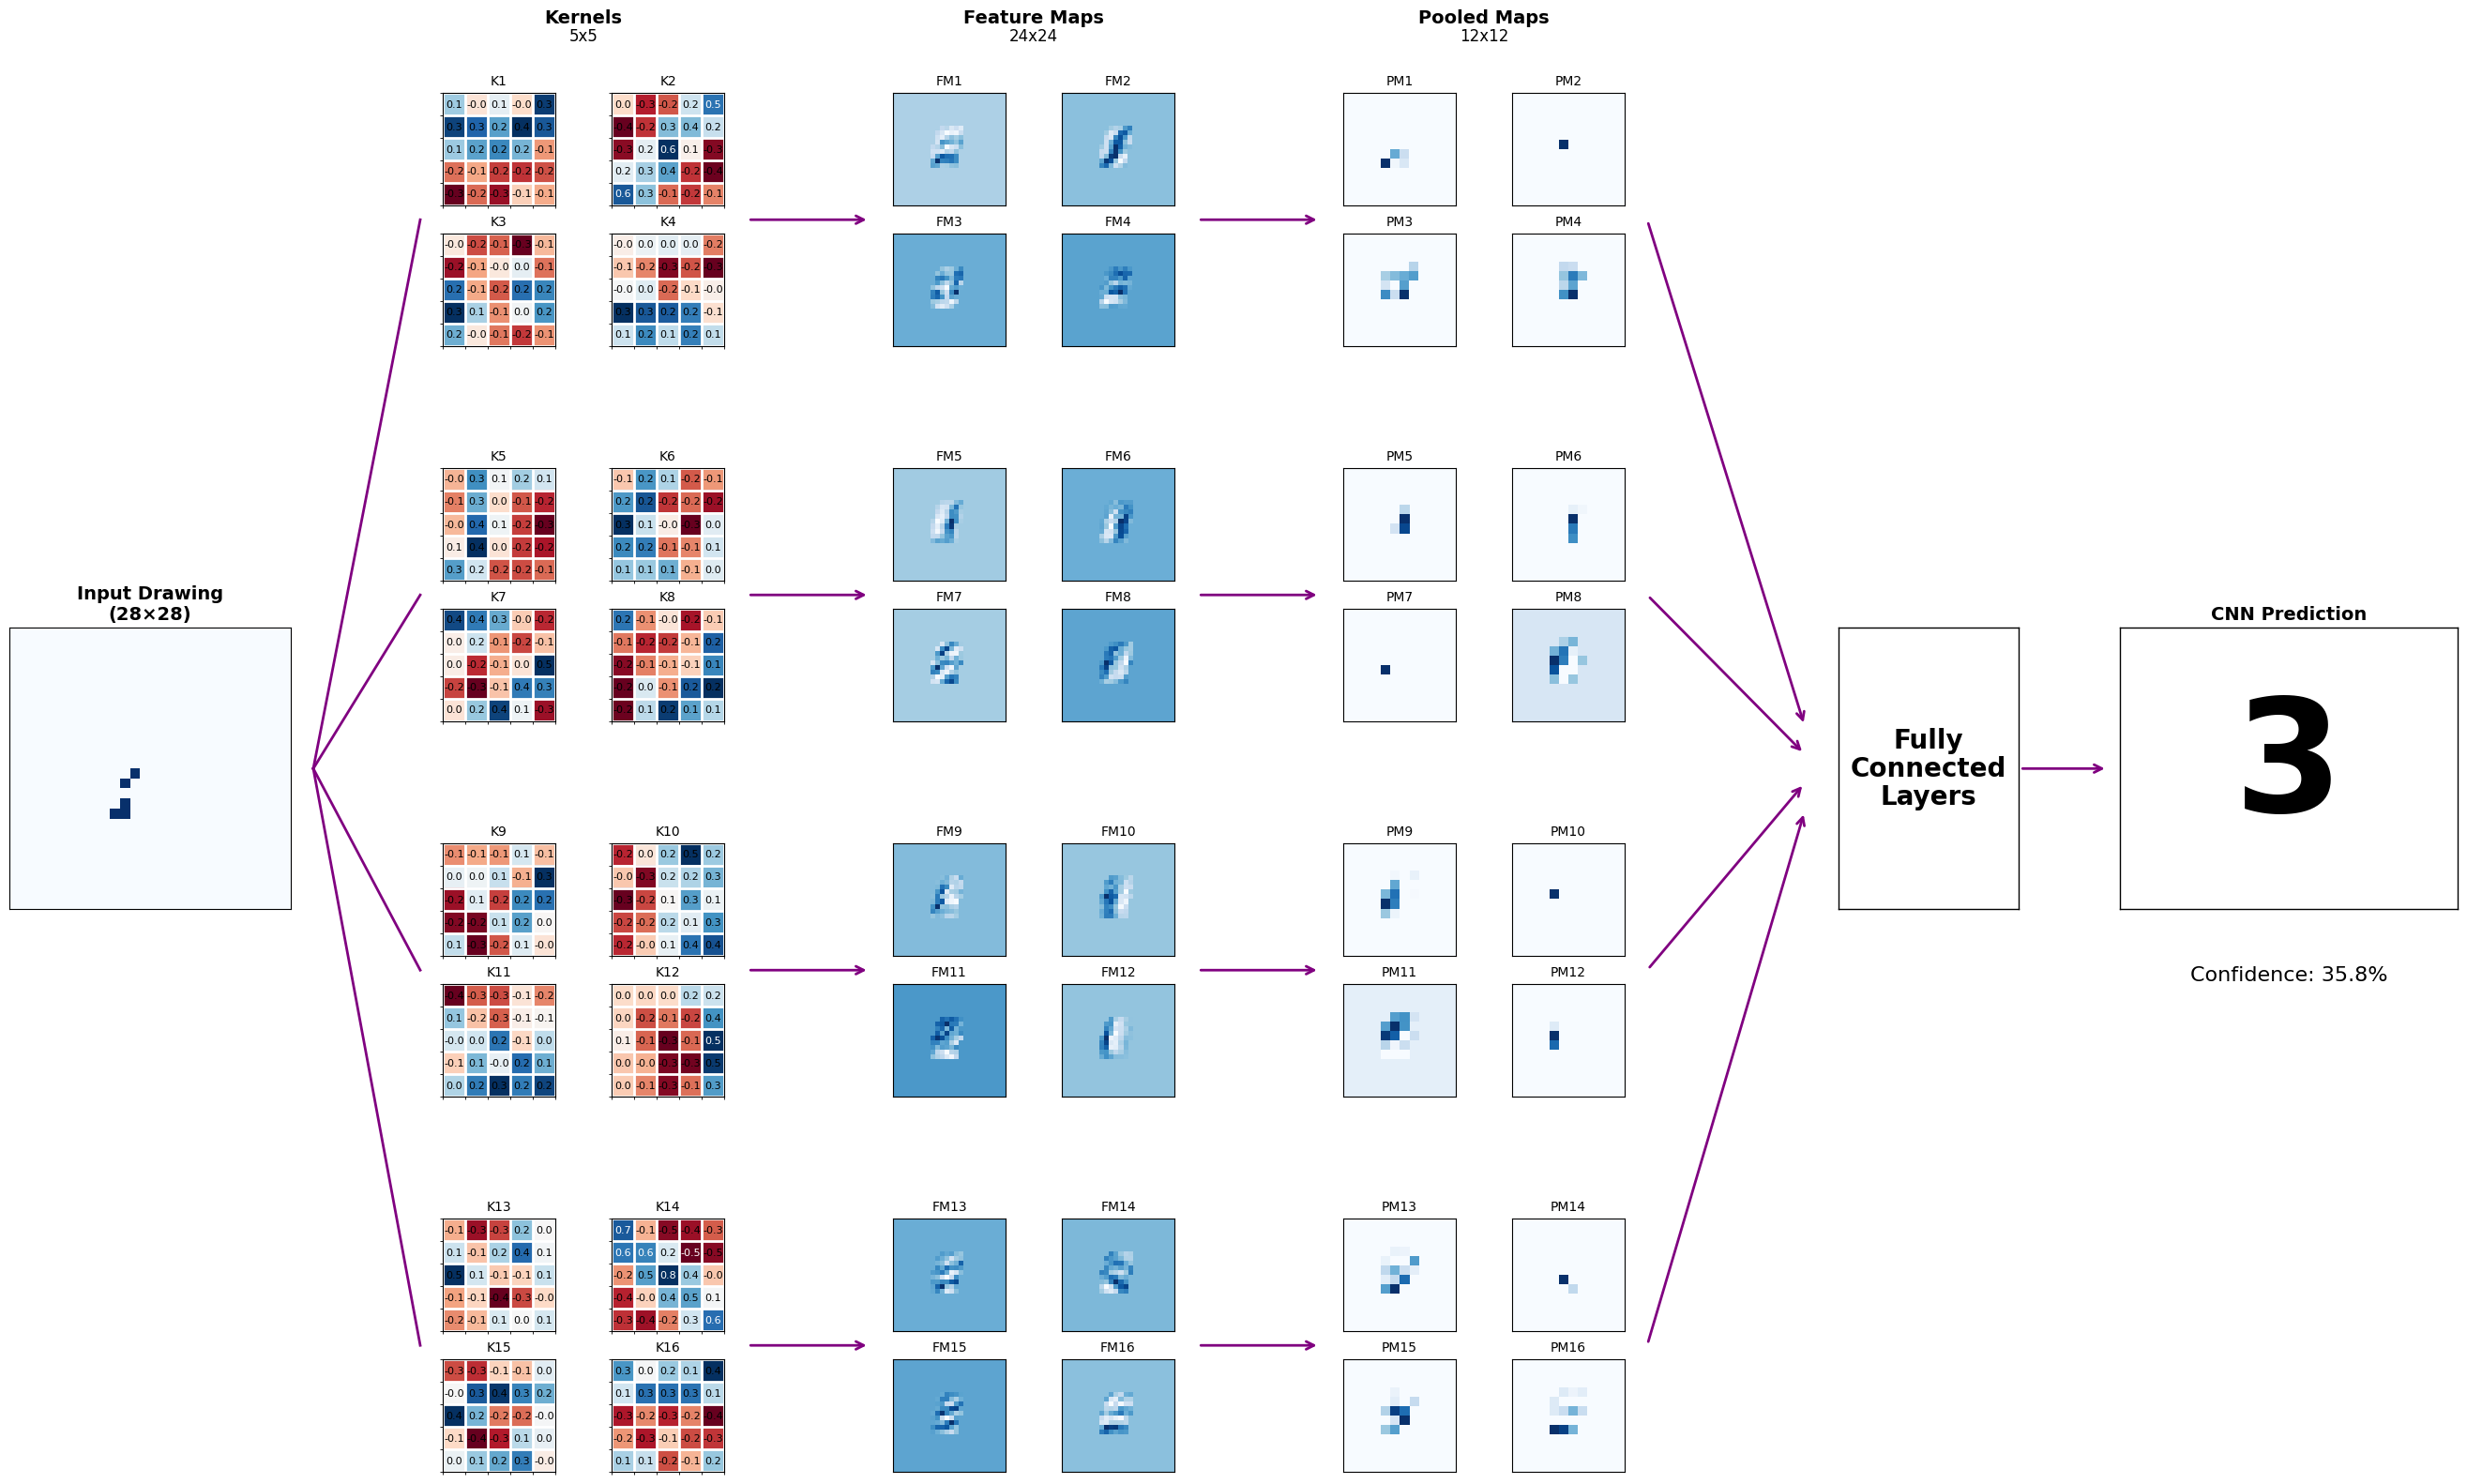

In [56]:
import pygame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy import ndimage
from scipy.signal import convolve2d



class MinimalCNN(nn.Module):
    def __init__(self):
        super(MinimalCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 12 * 12, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        conv_out = self.conv1(x)
        pooling = self.pool(F.relu(self.conv1(x)))
        vectorization = pooling.view(-1, 16 * 12 * 12)
        fc1 = F.relu(self.fc1(vectorization))
        fc1 = self.dropout(fc1)
        output = self.fc2(fc1)
        return output, conv_out, pooling, vectorization, fc1
        

def load_model():
    model = MinimalCNN()
    model.load_state_dict(torch.load('mnist_cnn.pth', map_location='cpu'))
    model.eval()
    return model
    

def center_and_normalize_digit(digit_array, target_size=20):
    rows, cols = np.where(digit_array > 0)
    
    if len(rows) == 0:
        return digit_array
    
    min_row, max_row = rows.min(), rows.max()
    min_col, max_col = cols.min(), cols.max()
    
    digit_region = digit_array[min_row:max_row+1, min_col:max_col+1]
    
    height, width = digit_region.shape
    scale = min(target_size / height, target_size / width)
    
    if scale < 1.0:
        new_height = int(height * scale)
        new_width = int(width * scale)
        digit_region = ndimage.zoom(digit_region, (new_height/height, new_width/width))
    
    centered_digit = np.zeros((28, 28))
    
    region_height, region_width = digit_region.shape
    start_row = (28 - region_height) // 2
    start_col = (28 - region_width) // 2
    
    centered_digit[start_row:start_row+region_height, start_col:start_col+region_width] = digit_region
    
    return centered_digit
    

def calculate_center_of_mass(digit_array):
    rows, cols = np.where(digit_array > 0)
    if len(rows) == 0:
        return 14, 14
    
    weights = digit_array[rows, cols]
    center_row = np.average(rows, weights=weights)
    center_col = np.average(cols, weights=weights)
    
    return center_row, center_col
    

def fine_tune_centering(digit_array):
    center_row, center_col = calculate_center_of_mass(digit_array)
    
    target_center = 13.5
    shift_row = int(round(target_center - center_row))
    shift_col = int(round(target_center - center_col))
    
    shift_row = max(-10, min(10, shift_row))
    shift_col = max(-10, min(10, shift_col))
    
    if shift_row != 0 or shift_col != 0:
        digit_array = ndimage.shift(digit_array, (shift_row, shift_col), cval=0.0)
    
    return digit_array
    

def preprocess_drawing(digit_array):
    centered = center_and_normalize_digit(digit_array)
    final = fine_tune_centering(centered)
    
    tensor = torch.FloatTensor(final)
    normalized = (tensor - 0.5) / 0.5
    input_tensor = normalized.unsqueeze(0).unsqueeze(0)
    
    return input_tensor, final
    

def predict_digit_improved(model, digit_array):
    input_tensor, processed_array = preprocess_drawing(digit_array)
    stages = []
    with torch.no_grad():
        outputs, conv_out, pooling, vectorization, fc1 = model(input_tensor)
        stages.append(conv_out)
        stages.append(pooling)
        stages.append(vectorization)
        stages.append(fc1)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    return predicted.item(), confidence.item(), probabilities.squeeze().numpy(), processed_array, stages
    

def draw_digit():
    WIDTH, HEIGHT = 560, 560
    BG_COLOR = (255, 255, 255)
    
    running = True
    grid_array = []
    
    pygame.init()
    window = pygame.display.set_mode((WIDTH, HEIGHT))
    pygame.display.set_caption("Draw Digit - Press ENTER when done")
    window.fill(BG_COLOR)
    
    def draw_grid():
        block_size = int(WIDTH/28)
        
        for i in range(28):
            for j in range(28):
                grid_block = pygame.Rect(i * block_size, j * block_size, block_size, block_size)
                color = (255, 255, 255)
                grid_array.append((grid_block, color))
    
    def draw_rectangles():
        for rect, color in grid_array:
            pygame.draw.rect(window, color, rect)
            pygame.draw.rect(window, (200, 200, 200), rect, 1)
    
    def get_digit_array():
        digit = np.zeros((28, 28))
        
        for row in range(28):
            for col in range(28):
                index = col * 28 + row
                rect, color = grid_array[index]
                
                if color == (0, 0, 0):
                    digit[row, col] = 0.9
        
        return digit
    
    def clear_grid():
        for i in range(len(grid_array)):
            rect, _ = grid_array[i]
            grid_array[i] = (rect, (255, 255, 255))
    
    draw_grid()
    
    print("- Click and drag to draw")
    print("- Press ENTER when finished")
    print("- Press SPACE to clear")
    
    digit_array = None
    clock = pygame.time.Clock()
    
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_RETURN:
                    digit_array = get_digit_array()
                    running = False
                    
                elif event.key == pygame.K_SPACE:
                    clear_grid()
        
        if pygame.mouse.get_pressed()[0]:
            mouse_pos = pygame.mouse.get_pos()
            for index, (rect, color) in enumerate(grid_array):
                if rect.collidepoint(mouse_pos):
                    grid_array[index] = (rect, (0, 0, 0))
        
        window.fill(BG_COLOR)
        draw_rectangles()
        pygame.display.flip()
        clock.tick(60)
    
    pygame.quit()
    return digit_array
    

class CNNVisualizer:
    def __init__(self, input_size=(28, 28), filter_size=(5, 5), num_filters=16):
        self.input_size = input_size
        self.filter_size = filter_size
        self.num_filters = num_filters
        self.output_size = (
            input_size[0] - filter_size[0] + 1,
            input_size[1] - filter_size[1] + 1
        )
        
        # Load model and get prediction
        self.model = load_model()
        self.input_data = draw_digit()
        
        # Get prediction
        if self.input_data is not None and np.sum(self.input_data) > 0:
            self.predicted_digit, self.confidence, _, _, stages = predict_digit_improved(self.model, self.input_data)
        else:
            self.predicted_digit, self.confidence = None, None
                
        filters = self.model.conv1.weight.data
        self.filters = []
        for i in range(filters.size(0)):
            self.filters.append(filters[i][0].detach().cpu().numpy())
        # Generate feature maps
        if self.input_data is not None:
            self.output_maps = stages[0].detach().cpu().numpy()
            self.output_maps = self.output_maps[0]
            self.pooling = stages[1].detach().cpu().numpy()
            self.pooling = self.pooling[0]
        else:
            self.output_maps = []

    
        def apply_convolution(self):
            output_maps = []
        
    #     for f in range(self.num_filters):
    #         _, processed_data = preprocess_drawing(self.input_data)
    #         output_map = convolve2d(processed_data, self.filters[f][::-1, ::-1], mode='valid')
    #         output_map += self.filter_bias[f]
            
    #         # for i in range(self.output_size[0]):
    #         #     for j in range(self.output_size[1]):
    #         #         # Should use the preprocessed version:
    #         #         _, processed_data = preprocess_drawing(self.input_data)
    #         #         patch = processed_data[i:i+self.filter_size[0], j:j+self.filter_size[1]]
    #         #         # patch = self.input_data[i:i+self.filter_size[0], j:j+self.filter_size[1]]
    #         #         output_map[i, j] = np.sum(patch * self.filters[f])
    #         #         output_map[i, j] = max(0, output_map[i, j] + self.filter_bias[f])
            
    #         output_maps.append(output_map)
        
            return output_maps

    
    def visualize_full_matrices(self, show_numbers_on_filters=True, decimals=1):
        if self.input_data is None:
            print("No drawing to visualize!")
            return
            
        # Set up the figure with grid layout (wider for 4th column)
        fig = plt.figure(figsize=(24, 20))
        
        def plot_matrix(ax, matrix, title, cmap='Blues', value_format='.1f', show_grid=True, show_numbers=False):
            im = ax.imshow(matrix, cmap=cmap, interpolation='nearest')
            ax.set_title(title, fontsize=10)
            
            if show_grid and matrix.shape[0] <= 10 and matrix.shape[1] <= 10:
                ax.set_xticks(np.arange(-.5, matrix.shape[1], 1), minor=True)
                ax.set_yticks(np.arange(-.5, matrix.shape[0], 1), minor=True)
                ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.set_xticks([])
                ax.set_yticks([])
            
            if show_numbers and matrix.shape[0] <= 10 and matrix.shape[1] <= 10:
                fontsize = 8 if matrix.shape[0] <= 5 else 6
                
                for i in range(matrix.shape[0]):
                    for j in range(matrix.shape[1]):
                        value = matrix[i, j]
                        text_color = 'white' if abs(value) > 0.5 else 'black'
                        if isinstance(value, (int, np.integer)):
                            value_str = f"{value}"
                        else:
                            value_str = f"{value:{value_format}}"
                        ax.text(j, i, value_str, ha='center', va='center', 
                               color=text_color, fontsize=fontsize)
                        
            return ax
        
        # All the lefts here for easy adjustment
        input_left = 0.05
        kernel_base_left = 0.25 
        feature_base_left = 0.45
        pooling_base_left = 0.65
        fc_left = 0.875  # Positioned after pooling maps
        prediction_left = 1

        # Calculate true center position based on actual top and bottom edges of all kernel blocks
        sub_height = 0.06
        v_spacing = 0.0001
        
        # Block 0 (top block): block_top = 0.85
        # - Top edge of block 0 = 0.85 + sub_height = 0.91
        top_edge = 0.85 + sub_height
        
        # Block 3 (bottom block): block_top = 0.25
        # - Bottom edge of block 3 = 0.25 - (sub_height + v_spacing) = 0.1899
        bottom_edge = (0.85 - (3 * 0.2)) - (sub_height + v_spacing)
        
        # True center between highest and lowest points
        true_center = (top_edge + bottom_edge) / 2
        
        # Center both input and prediction boxes at this true center
        box_height = 0.15
        centered_bottom = true_center - box_height / 2
        
        # Plot the input data (left column, perfectly centered)
        input_bottom = centered_bottom
        input_width = 0.15
        input_height = 0.15
        ax_input = fig.add_axes([input_left, input_bottom, input_width, input_height])
        plot_matrix(ax_input, self.input_data, 'Input Drawing\n(28×28)', show_numbers=False)
        ax_input.set_title('Input Drawing\n(28×28)', fontsize=14, fontweight = 'bold')
        
        # Store axes for arrows
        kernel_block_axes = []
        output_block_axes = []
        pooling_block_axes = []
        

        # Plot all kernels and feature maps in 4 vertical 2x2 blocks
        for block_num in range(4):
            block_kernel_axes = []
            block_output_axes = []
            block_pooling_axes = []
            
            block_top = 0.85 - (block_num * 0.2)
            
            for sub_row in range(2):
                for sub_col in range(2):
                    f = block_num * 4 + sub_row * 2 + sub_col
                    
                    kernel_base_left = 0.25  # Adjusted to match gap from feature maps to prediction
                    feature_base_left = 0.45
                    pooling_base_left = 0.65
                    
                    sub_width = 0.06
                    sub_height = 0.06
                    
                    h_spacing = 0.015
                    v_spacing = 0.015
                    
                    left_kernel = kernel_base_left + sub_col * (sub_width + h_spacing)
                    left_feature = feature_base_left + sub_col * (sub_width + h_spacing)
                    left_pooling = pooling_base_left + sub_col * (sub_width + h_spacing)
                    bottom = block_top - sub_row * (sub_height + v_spacing)
                    
                    # Plot kernel
                    ax_filter = fig.add_axes([left_kernel, bottom, sub_width, sub_height])
                    plot_matrix(ax_filter, self.filters[f], f'K{f+1}', cmap='RdBu', show_numbers=show_numbers_on_filters)
                    block_kernel_axes.append(ax_filter)
                    
                    # Plot corresponding feature map
                    ax_output = fig.add_axes([left_feature, bottom, sub_width, sub_height])
                    plot_matrix(ax_output, self.output_maps[f], f'FM{f+1}', show_numbers=False)
                    block_output_axes.append(ax_output)

                    # Plot pooled feature maps
                    ax_pooling = fig.add_axes([left_pooling, bottom, sub_width, sub_height])
                    plot_matrix(ax_pooling, self.pooling[f], f'PM{f+1}', cmap='Blues', show_numbers=False)
                    block_pooling_axes.append(ax_pooling)
            
            kernel_block_axes.append((block_num, block_kernel_axes))
            output_block_axes.append((block_num, block_output_axes))
            pooling_block_axes.append((block_num, block_pooling_axes))

        # New: Fully Connected Layers box
        fc_bottom = centered_bottom  # Same vertical center as input and prediction
        fc_width = 0.08
        fc_height = 0.15
        ax_fc = fig.add_axes([fc_left, fc_bottom, fc_width, fc_height])
        
        # Add text with each word on a new line
        ax_fc.text(0.5, 0.6, 'Fully', ha='center', va='center', fontsize=20, fontweight='bold', transform=ax_fc.transAxes)
        ax_fc.text(0.5, 0.5, 'Connected', ha='center', va='center', fontsize=20, fontweight='bold', transform=ax_fc.transAxes)
        ax_fc.text(0.5, 0.4, 'Layers', ha='center', va='center', fontsize=20, fontweight='bold', transform=ax_fc.transAxes)
        
        ax_fc.set_xlim(0, 1)
        ax_fc.set_ylim(0, 1)
        ax_fc.set_xticks([])
        ax_fc.set_yticks([])

        # Add border
        for spine in ax_fc.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1)

        # 4th column: Prediction result
        if self.predicted_digit is not None:
            # Prediction box exactly matches input box size and position for symmetry
            prediction_bottom = centered_bottom  # Same as input box
            prediction_width = 0.15   # Same as input box
            prediction_height = 0.15  # Same as input box
            
            ax_prediction = fig.add_axes([prediction_left, prediction_bottom, prediction_width, prediction_height])
            
            # Create a square with the predicted number
            ax_prediction.text(0.5, 0.5, str(self.predicted_digit), ha='center', va='center', 
                             fontsize=120, fontweight='bold', transform=ax_prediction.transAxes)
            
            ax_prediction.set_xlim(0, 1)
            ax_prediction.set_ylim(0, 1)
            ax_prediction.set_xticks([])
            ax_prediction.set_yticks([])
            ax_prediction.set_title('CNN Prediction', fontsize=14, fontweight='bold')
            
            # Add border
            for spine in ax_prediction.spines.values():
                spine.set_visible(True)
                spine.set_linewidth(1)
            
            # Add confidence text below the box
            confidence_percentage = self.confidence * 100
            fig.text(prediction_left + prediction_width/2, prediction_bottom - 0.03, 
                    f'Confidence: {confidence_percentage:.1f}%', 
                    ha='center', va='top', fontsize=16, transform=fig.transFigure)
        
        # labels
        
        # Kernels
        kernel_center = kernel_base_left + (sub_width + h_spacing/2)  # Center of the kernel blocks
        fig.text(kernel_center, 0.95, 'Kernels', ha='center', va='center', fontsize=14, fontweight='bold')
        fig.text(kernel_center, 0.94, '5x5', ha='center', va='center', fontsize=12)
        
        # Feature Maps
        feature_center = feature_base_left + (sub_width + h_spacing/2)
        fig.text(feature_center, 0.95, 'Feature Maps', ha='center', va='center', fontsize=14, fontweight='bold')
        fig.text(feature_center, 0.94, '24x24', ha='center', va='center', fontsize=12)
        
        # 4. Pooled Maps (PM1-PM16)
        pooling_center = pooling_base_left + (sub_width + h_spacing/2)
        fig.text(pooling_center, 0.95, 'Pooled Maps', ha='center', va='center', fontsize=14, fontweight='bold')
        fig.text(pooling_center, 0.94, '12x12', ha='center', va='center', fontsize=12)
        
        # Draw arrows using figure coordinates
        fig.canvas.draw()
        
        # Updated input box position for arrows
        input_bbox = ax_input.get_position()
        input_right = input_bbox.x1
        input_center_y = (input_bbox.y0 + input_bbox.y1) / 2
        
        def add_straight_arrow(fig, start_x, start_y, end_x, end_y, color='purple', width=2.0):
            arrow = patches.FancyArrowPatch(
                (start_x, start_y), (end_x, end_y),
                arrowstyle='->', color=color, linewidth=width,
                connectionstyle='arc3,rad=0',
                shrinkA=3, shrinkB=3,
                mutation_scale=15,
                transform=fig.transFigure, zorder=0
            )
            fig.add_artist(arrow)

        def add_straight_line(fig, start_x, start_y, end_x, end_y, color='purple', width=2.0):
            line = Line2D(
                [start_x, end_x], [start_y, end_y],
                color=color, linewidth=width,
                transform=fig.transFigure, zorder=0
            )
            fig.add_artist(line)
        
        # Add arrows from input to each 2x2 kernel block
        for block_num, block_axes in kernel_block_axes:
            if block_axes:
                all_positions = []
                for ax in block_axes:
                    bbox = ax.get_position()
                    all_positions.extend([
                        (bbox.x0, bbox.y0),
                        (bbox.x1, bbox.y1)
                    ])
                
                if all_positions:
                    block_left = min(pos[0] for pos in all_positions) - 0.01
                    block_top = max(pos[1] for pos in all_positions)
                    block_bottom = min(pos[1] for pos in all_positions)
                    block_center_y = (block_top + block_bottom) / 2
                    
                    add_straight_line(fig, input_right + 0.01, input_center_y, block_left, block_center_y, color='purple')
        # Modified: Arrows from kernels to feature maps
        for (k_block_num, k_axes), (o_block_num, o_axes) in zip(kernel_block_axes, output_block_axes):
            if k_axes and o_axes and k_block_num == o_block_num:
                k_positions = []
                for ax in k_axes:
                    bbox = ax.get_position()
                    k_positions.extend([
                        (bbox.x0, bbox.y0),
                        (bbox.x1, bbox.y1)
                    ])
                o_positions = []
                for ax in o_axes:
                    bbox = ax.get_position()
                    o_positions.extend([
                        (bbox.x0, bbox.y0),
                        (bbox.x1, bbox.y1)
                    ])
                if k_positions and o_positions:
                    k_right = max(pos[0] for pos in k_positions) + 0.01
                    k_top = max(pos[1] for pos in k_positions)
                    k_bottom = min(pos[1] for pos in k_positions)
                    k_center_y = (k_top + k_bottom) / 2
                    o_left = min(pos[0] for pos in o_positions) - 0.01
                    o_top = max(pos[1] for pos in o_positions)
                    o_bottom = min(pos[1] for pos in o_positions)
                    o_center_y = (o_top + o_bottom) / 2
                    add_straight_arrow(fig, k_right, k_center_y, o_left, o_center_y, color='purple')
        
        # New: Arrows from feature maps to pooling maps
        for (o_block_num, o_axes), (p_block_num, p_axes) in zip(output_block_axes, pooling_block_axes):
            if o_axes and p_axes and o_block_num == p_block_num:
                o_positions = []
                for ax in o_axes:
                    bbox = ax.get_position()
                    o_positions.extend([
                        (bbox.x0, bbox.y0),
                        (bbox.x1, bbox.y1)
                    ])
                p_positions = []
                for ax in p_axes:
                    bbox = ax.get_position()
                    p_positions.extend([
                        (bbox.x0, bbox.y0),
                        (bbox.x1, bbox.y1)
                    ])
                if o_positions and p_positions:
                    o_right = max(pos[0] for pos in o_positions) + 0.01
                    o_top = max(pos[1] for pos in o_positions)
                    o_bottom = min(pos[1] for pos in o_positions)
                    o_center_y = (o_top + o_bottom) / 2
                    p_left = min(pos[0] for pos in p_positions) - 0.01
                    p_top = max(pos[1] for pos in p_positions)
                    p_bottom = min(pos[1] for pos in p_positions)
                    p_center_y = (p_top + p_bottom) / 2
                    add_straight_arrow(fig, o_right, o_center_y, p_left, p_center_y, color='purple')
        
        if self.predicted_digit is not None and pooling_block_axes:
            fc_center_y = fc_bottom + fc_height / 2
            fc_left = fc_left - 0.015
            
            for block_num, block_axes in pooling_block_axes:
                if block_axes:
                    block_positions = []
                    for ax in block_axes:
                        bbox = ax.get_position()
                        block_positions.extend([
                            (bbox.x0, bbox.y0),
                            (bbox.x1, bbox.y1)
                        ])
                    if block_positions:
                        block_right = max(pos[0] for pos in block_positions) + 0.01
                        block_top = max(pos[1] for pos in block_positions)
                        block_bottom = min(pos[1] for pos in block_positions)
                        block_center_y = (block_top + block_bottom) / 2
                        box_height = fc_height
                        box_center = fc_center_y
                        spread_range = box_height * 0.3
                        if block_num == 0:
                            target_y = box_center + spread_range * 0.5
                        elif block_num == 1:
                            target_y = box_center + spread_range * 0.17
                        elif block_num == 2:
                            target_y = box_center - spread_range * 0.17
                        else:
                            target_y = box_center - spread_range * 0.5
                        add_straight_arrow(fig, block_right, block_center_y, fc_left, target_y, color='purple')
        
        # Arrow from fully connected layers to prediction
        if self.predicted_digit is not None:
            fc_right = fc_left + fc_width + 0.015
            fc_center_y = fc_bottom + fc_height / 2
            pred_center_y = prediction_bottom + prediction_height / 2
            pred_left = prediction_left - 0.005
            add_straight_arrow(fig, fc_right, fc_center_y, pred_left, pred_center_y, color='purple')

        # Arrows from pooling maps to prediction
        # if self.predicted_digit is not None and pooling_block_axes:
        #     pred_center_y = prediction_bottom + prediction_height / 2
        #     pred_left = prediction_left - 0.015
            
        #     for block_num, block_axes in pooling_block_axes:
        #         if block_axes:
        #             block_positions = []
        #             for ax in block_axes:
        #                 bbox = ax.get_position()
        #                 block_positions.extend([
        #                     (bbox.x0, bbox.y0),
        #                     (bbox.x1, bbox.y1)
        #                 ])
        #             if block_positions:
        #                 block_right = max(pos[0] for pos in block_positions) + 0.01
        #                 block_top = max(pos[1] for pos in block_positions)
        #                 block_bottom = min(pos[1] for pos in block_positions)
        #                 block_center_y = (block_top + block_bottom) / 2
        #                 box_height = prediction_height
        #                 box_center = pred_center_y
        #                 spread_range = box_height * 0.3
        #                 if block_num == 0:
        #                     target_y = box_center + spread_range * 0.5
        #                 elif block_num == 1:
        #                     target_y = box_center + spread_range * 0.17
        #                 elif block_num == 2:
        #                     target_y = box_center - spread_range * 0.17
        #                 else:
        #                     target_y = box_center - spread_range * 0.5
        #                 add_straight_arrow(fig, block_right, block_center_y, pred_left, target_y, color='purple')
        
        # #plt.tight_layout()
        plt.show()

def main():

    try:
        visualizer = CNNVisualizer()
        if visualizer.input_data is not None and np.sum(visualizer.input_data) > 0:
            visualizer.visualize_full_matrices()
        else:
            print("No drawing detected or drawing is empty")
    except FileNotFoundError:
        print("Could not find 'mnist_cnn.pth' model file")
        print("Make sure the CNN is in the same directory")
    except Exception as e:
        print(f"Error: {e}")
        print("Make sure you have the required libraries installed:")
        print("torch torchvision pygame matplotlib scipy")

if __name__ == "__main__":
    main()

- Click and drag to draw
- Press ENTER when finished
- Press SPACE to clear


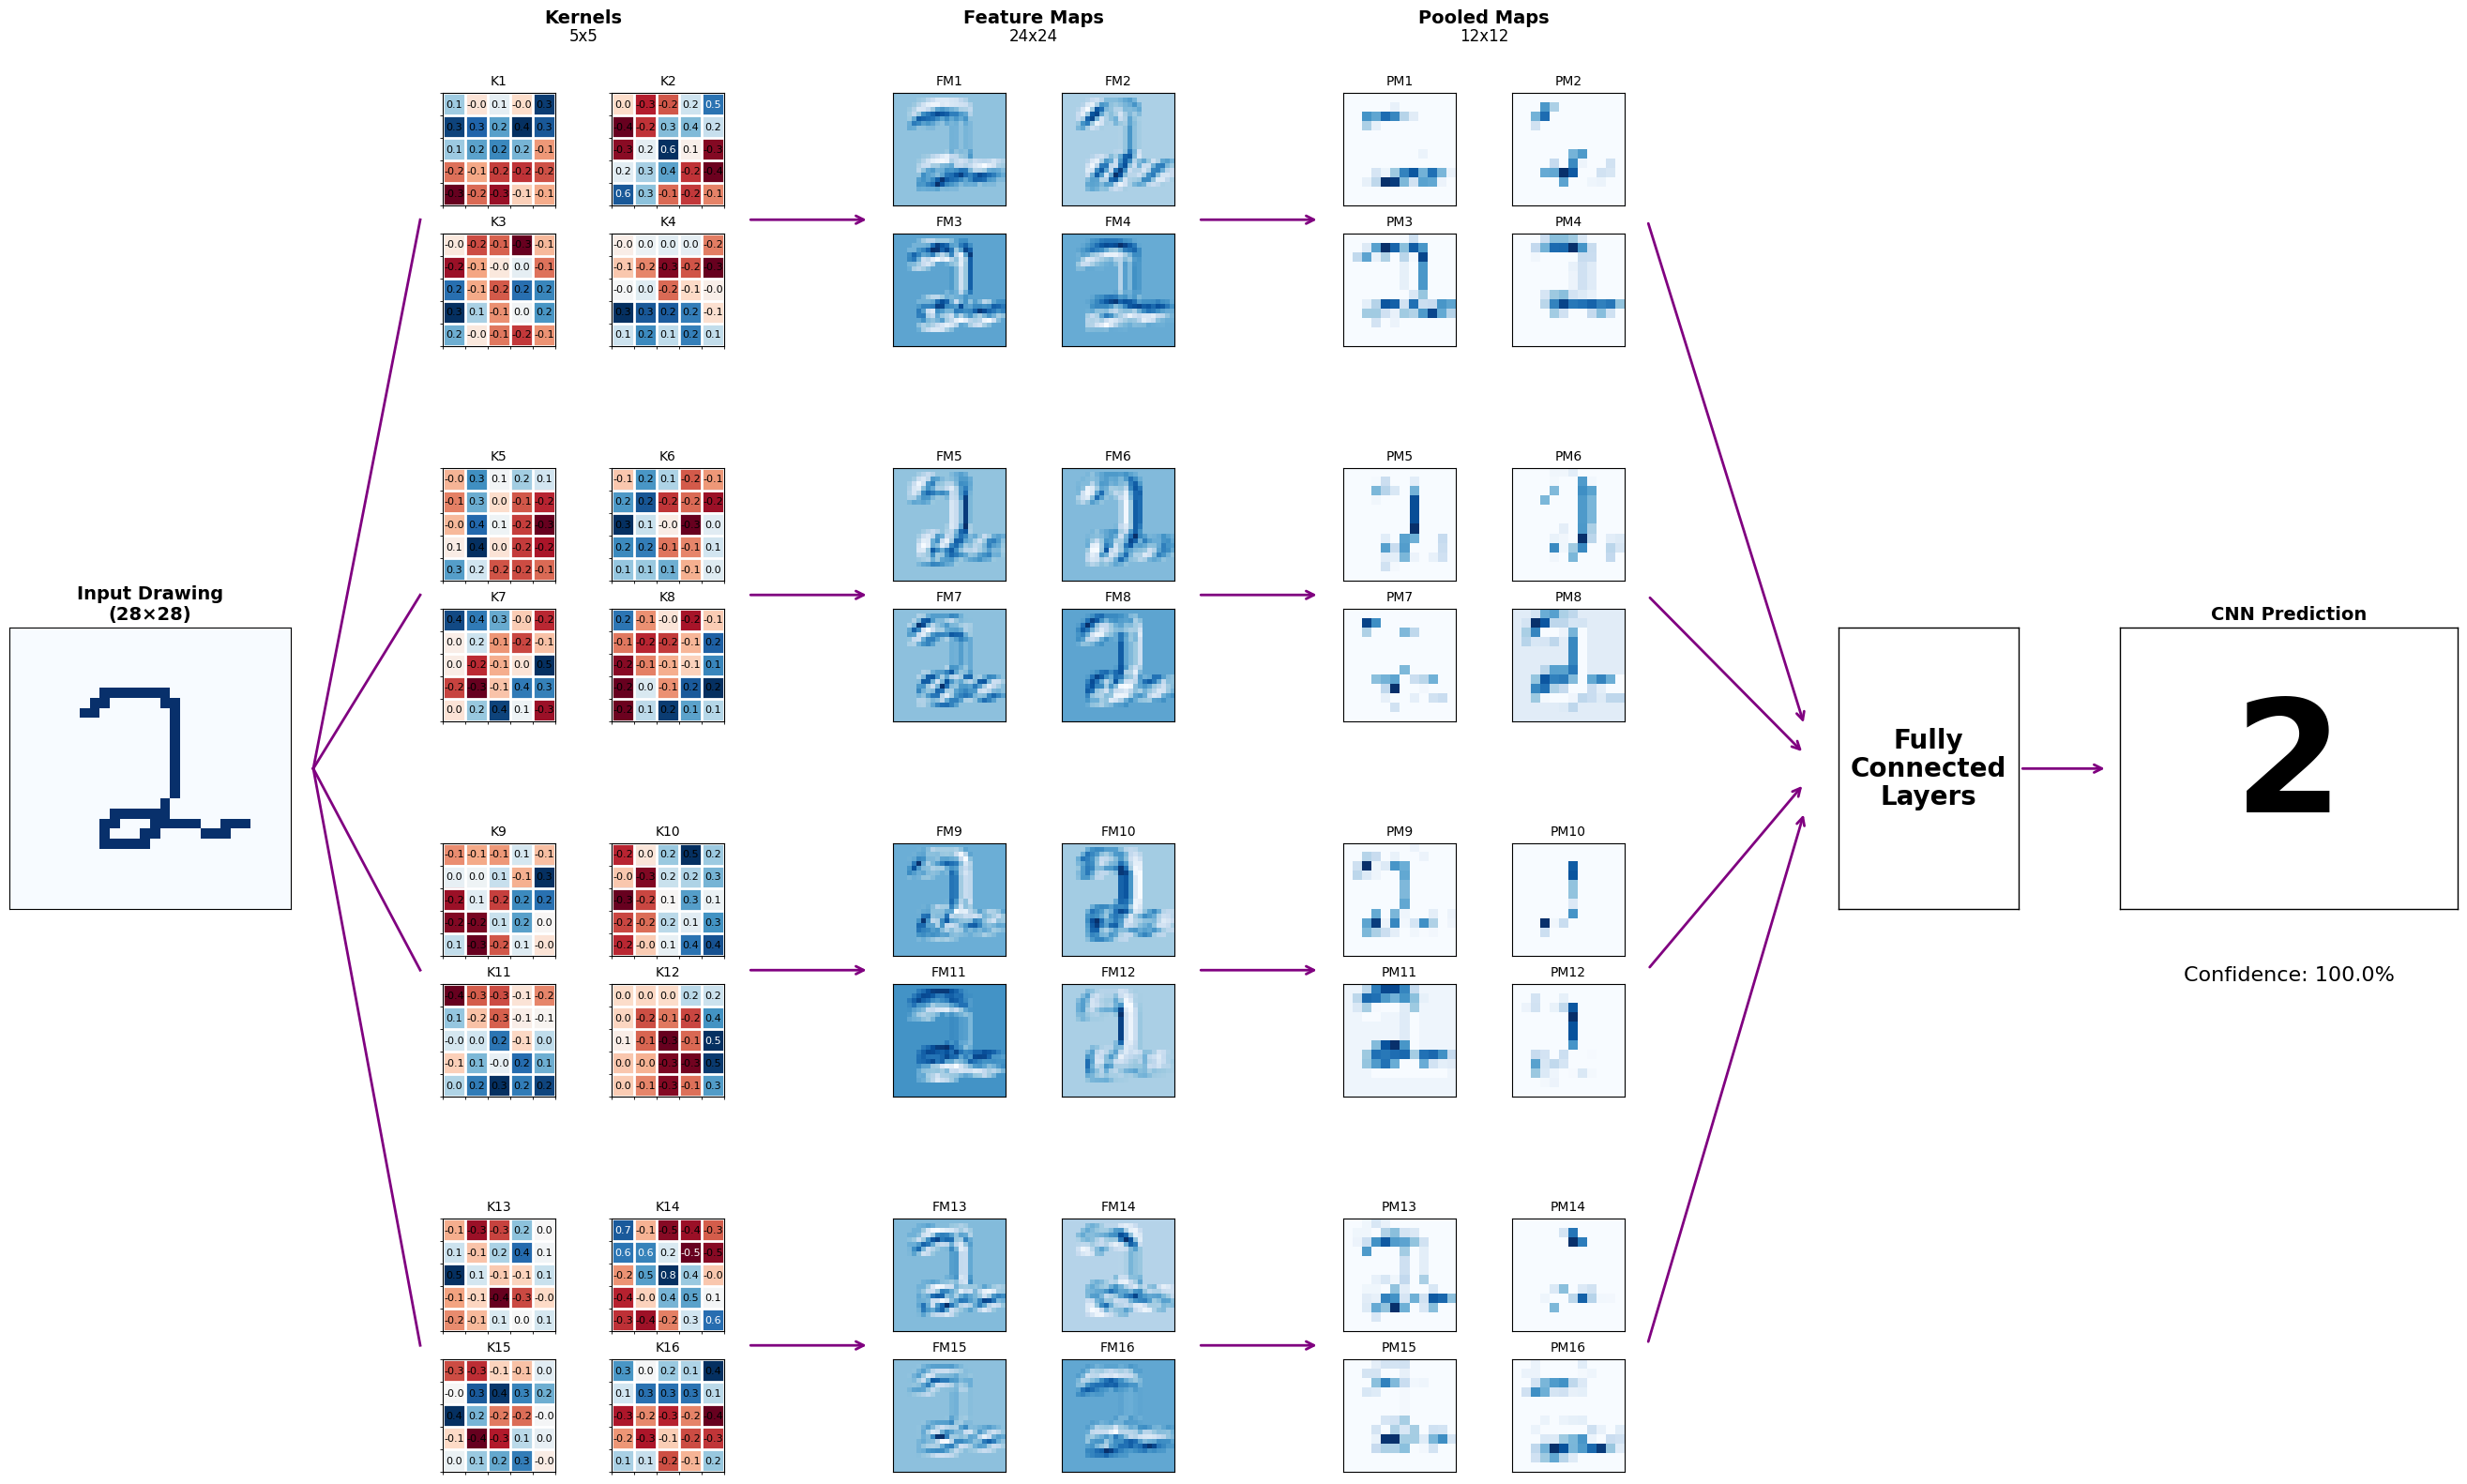

In [57]:
main()